Notebook em complemento aos meus outros trabalhos, todos então disponíveis em meu github. Esse é um dos desafios disponíveis no Kaggle sobre o covid-19, e tentarei durante o trabalho realizar algumas das taferas.

https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/tasks


O dataset disponível hoje, tem um total de mais de 13GB e 120 mil artigos, no que eu trabalharei possui cerca de 3GB e 20 mil artigos.
Um dos motivos pelo qual não utilizarei o de 13GB é de que utilizaria muita memória e tomaria muito tempo, e esse não é o propósito. O propósito é de apresentar pequenas soluções e demonstrar como o uso do machine learning poderá ajudar os profissionais de saúdes no combate ao covid-19

Esse trabalho será divido em 2 partes:

Primeira parte a de exploração de dados dos artigos científicos, onde buscarei algumas respostas pelos desafios e como de uma maneira facil poderemos responder todos eles

Segunda parte é a simulação de predições com a base de dados disponível pelo ministério da saúde. 


Começaremos pelo tratamento dos dados:

In [1]:
#import glob, json, zipfile
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap
from bokeh.io import output_file, show
from bokeh.transform import transform
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import column
from bokeh.models import RadioButtonGroup
from bokeh.models import TextInput
from bokeh.layouts import gridplot
from bokeh.models import Div
from bokeh.models import Paragraph
from bokeh.layouts import column, widgetbox


import numpy as np
import pandas as pd
import seaborn as sns
import spacy, scispacy, operator
import matplotlib.pyplot as plt
import en_core_sci_md

from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.core.display import HTML
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from statsmodels.tools.eval_measures import rmse, mse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.tools import diff
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
"""from google.colab import drive
drive.mount("/content/gdrive")"""

"""import zipfile
path = '/content/gdrive/My Drive/CORD-19-research-challenge.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()""";

In [ ]:
corona_features = {'paper_id': [], 'title': [],
                   'abstract': [], 'text': []}

corona_df = pd.DataFrame.from_dict(corona_features)

json_filenames = glob.glob(f'{"./"}//**/*.json', recursive = True)

In [ ]:
def return_corona_df(json_filenames, df):
    for file_name in json_filenames:
        row = {'paper_id': None, 'title': None,
           'abstract': None,'text': None}
    
        with open(file_name) as json_data:
            try:
                if file_name == "./sample_data/anscombe.json":
                    continue
      
                data = json.load(json_data)

                row['paper_id'] = data['paper_id'].strip()
                row['title'] = data['metadata']['title'].strip()

                abstract_list = [abstract['text'] for abstract in data['abstract']]
                abstract = '\n '.join (abstract_list)
                row['abstract'] = abstract.strip()

                text_list = [text['text'] for text in data['body_text']]
                text = '\n '.join(text_list)
                row['text'] = text.strip()

                df = df.append(row, ignore_index = True)
            except:
                pass 
    return df

In [ ]:
corona_df = return_corona_df(json_filenames, corona_df)
corona_df.head()
corona_df = corona_df[corona_df['title']!= ""]
corona_df = corona_df[corona_df['abstract']!= ""]
corona_df.drop_duplicates(['abstract','text','title'], inplace=True)
corona_df.shape
corona_df.to_csv("pre_processado.csv")

In [ ]:
nlp = en_core_sci_md.load(disable = ['tagger', 'parser', 'ner'])
nlp.max_length = 2000000

In [ ]:
new_stop_words = ['et', 'al','doi','cppyright','http', 
                  'https', 'fig','table','result','show']
for word in new_stop_words:
    nlp.vocab[word].is_stop = True

Durante o tratamento dos dados realizaremos a lemmatização, e a função abaixo servirá para isso.


A lematização é uma técnica, geralmente utilizada por buscador de palavras em sites, para abranger a quantidade de opções de palavras relacionadas a palavra buscada, ignorando o tempo verbal caso seja um verbo, o gênero da palavra, o plural e etc.

Por exemplo, as palavras pensamento, pensando, e derivadas delas serão trocadas todas por "pensar", facilitando assim a "padronização" do texto.

Serão retirados também todos os números (que estão sozinhos), stop words (palavras de ligação que são irrelevantes ao conjunto dos resultados), pontuações e espaços indevidos 

In [2]:
def spacy_tokenizer(sentence):
    sentence = sentence.lower()
    lista = []
    lista = [word.lemma_ for word in nlp(sentence) if not (word.is_stop or
                                                         word.like_num or
                                                         word.is_punct or 
                                                         word.is_space or
                                                         len(word)==1)]
    lista = ' '.join([str(element) for element in lista])
    return lista

In [ ]:
corona_df['text'] = corona_df['text'].apply(spacy_tokenizer)

In [ ]:
corona_df.to_csv("pos_processamento.csv", encoding = "UTF-8")

In [3]:
corona_df_completo = pd.read_csv("pos_processamento.csv", index_col = 0)

In [4]:
corona_df_completo.head()

,paper_id,title,abstract,text
0,313dd0869f169624e78d770963eacb0d1641cafa,Structure of M pro from COVID-19 virus and dis...,A new coronavirus (CoV) identified as COVID-19...,kinetic analysis extend datum fig. 1e catalyti...
1,5ba386b58c8d194e8cbe581eed95f7c64d05cd53,A Toolkit for Rapid Modular Construction of Bi...,The ability to rapidly assemble and prototype ...,molecular clone cornerstone modern biological ...
2,bfed3ce6a6df2d442d96d0cab07d4bc1f2347255,Seattle Flu Study -Swab and Send: Study Protoc...,While seasonal influenza and other respiratory...,acute respiratory illness aris pose significan...
3,ee3aa97a0ad91231296bd0643136c83bb97af88a,Multi-city modeling of epidemics using spatial...,The ongoing pandemic of 2019-nCov (COVID-19) c...,follow onset wuhan china pandemic 2019-ncov co...
4,a34d2c1876ffedc4f95f3af13ac06039cd38a5b0,Estimating the infection and case fatality rat...,Adjusting for delay from confirmation-to-death...,real-time estimate case fatality ratio cfr inf...


Após o tratamento de dados podemos ver como ficou um dos textos

In [5]:
corona_df_completo.iloc[0]["text"]

'kinetic analysis extend datum fig. 1e catalytic efficiency kcat/km covid-19 virus pro measure −1 −1 slightly high sars- cov pro kcat/km=26,500 −1 −1 30-fold high human rhinovirus 3c protease kcat/km=920 −1 −1 previous study design michael acceptor inhibitor n3 computer-aided drug design cadd extend datum fig. 1c specifically inhibit multiple cov utilize evaluate inhibition approximation pseudo second-order rate 11,300±880 suggest michael acceptor potent inhibition crystal structure covid-19 virus pro complex n3 order elucidate inhibitory mechanism compound determine crystal structure covid-19 virus pro complex n3 2.1-å resolution asymmetric unit contain polypeptide extend datum associate form dimer crystallographic 2-fold symmetry axis molecule designate protomer fig. 1b residue residue visible electron density map protomer compose domain fig. 1a domain residue residue antiparallel β-barrel structure domain residue contain α-helices arrange largely antiparallel globular cluster connec

In [6]:
corona_df_completo.dropna(inplace=True)
print(corona_df_completo.shape)

(20209, 4)


In [7]:
dataset_texts = corona_df_completo['text'].tolist()

In [8]:
len(dataset_texts)

20209

In [9]:
tfidf = TfidfVectorizer(max_features=2**12) #utilização desse vetor para limitação do tamanho da matriz esparsa
vectorized = tfidf.fit_transform(dataset_texts)
vectorized

<20209x4096 sparse matrix of type '<class 'numpy.float64'>'
	with 11337072 stored elements in Compressed Sparse Row format>

In [10]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(vectorized.toarray())
components = pca.explained_variance_ratio_

Text(0, 0.5, 'WCSS')

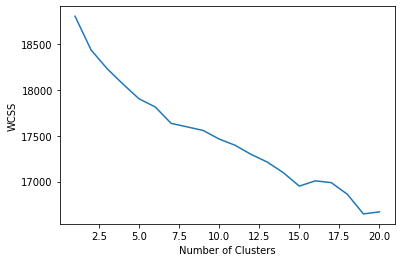

In [11]:
wcss = []
for i in range(1,21):
    kmeans = MiniBatchKMeans(n_clusters = i, random_state = 0)
    kmeans.fit(vectorized)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,21), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel("WCSS")

A seguir será feita a definição dos clusters, apesar do gráfico demonstar que seriam interessantes 15 clusters, apenas para fins de demonstração, farei apenas com 5 grupos para uma melhor visualização, o interessante que conforme passamos o mouse pelos pontos, podemos ler cada um dos títulos e o contexto do artigo

In [12]:
k = 5
kmeans = MiniBatchKMeans(n_clusters=k, random_state=16)
y_pred = kmeans.fit_predict(vectorized)

Text(0.5, 1.0, 'Covid-19 Papers')

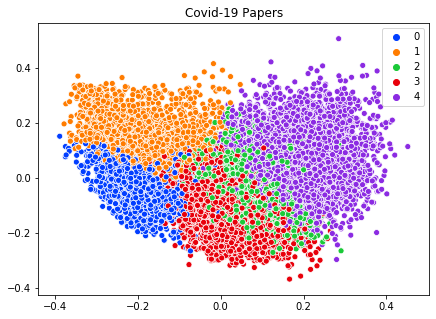

In [13]:
plt.figure(figsize=(7,5))
sns.scatterplot(X_pca[:,0], X_pca[:,1], hue=y_pred,palette="bright")
plt.title("Covid-19 Papers")

In [ ]:
output_notebook()
y_labels = y_pred

# data sources
source = ColumnDataSource(data=dict(
    x= X_pca[:,0], 
    y= X_pca[:,1],
    x_backup = X_pca[:,0],
    y_backup = X_pca[:,1],
    desc= y_labels, 
    titles= corona_df_completo['title'],
    abstract = corona_df_completo['abstract'],
    labels = ["C-" + str(x) for x in y_labels]
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Abstract", "@abstract{safe}"),
],
                 point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[9],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
p = figure(plot_width=800, plot_height=800, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset'], 
           title="Covid-19 Papers", 
           toolbar_location="right")

# plot
p.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend = 'labels')

# add callback to control 
callback = CustomJS(args=dict(p=p, source=source), code="""
            
            var radio_value = cb_obj.active;
            var data = source.data; 
            
            x = data['x'];
            y = data['y'];
            
            x_backup = data['x_backup'];
            y_backup = data['y_backup'];
            
            labels = data['desc'];
            
            if (radio_value == '5') {
                for (i = 0; i < x.length; i++) {
                    x[i] = x_backup[i];
                    y[i] = y_backup[i];
                }
            }
            else {
                for (i = 0; i < x.length; i++) {
                    if(labels[i] == radio_value) {
                        x[i] = x_backup[i];
                        y[i] = y_backup[i];
                    } else {
                        x[i] = undefined;
                        y[i] = undefined;
                    }
                }
            }


        source.change.emit();
        """)


# option
option = RadioButtonGroup(labels=["C-0", "C-1", "C-2",
                                  "C-3", "C-5",
                                   "All"], 
                          active=5, callback=callback)

#header
header = Div(text="""<h1>Covid-19 Papers</h1>""")

# show

show(column(header, widgetbox(option),p))

![title](img/imagem2.jpg)

Até agora foi utilizado o dataset completo, a partir desse ponto, utilizarei apenas uma amostra de 500 artigos para que não demore muito tempo. O propósito é demonstrar as ferramentas e como podem ser utilizadas

In [14]:
corona_df = corona_df_completo.copy()
corona_df = corona_df.sample(n = 500, random_state = 0)
corona_df.head()

,paper_id,title,abstract,text
14598,98e85066186167e53509cadef5d5389f2087da2e,Mesodynamics in the SARS nucleocapsid measured...,Protein motions on all timescales faster than ...,dynamic nature protein key element function pr...
25534,76241f85fbee07bdf466214c02c4bccd79706436,Novel circular single-stranded DNA viruses ide...,"Rosario K, Schenck RO, Harbeitner RC, Lawler S...",viral metagenomics shotgun sequence total nucl...
21047,874e540a730ee1060365af8d2caa03f537508e33,A Human DPP4-Knockin Mouse's Susceptibility to...,Infection by the Middle East respiratory syndr...,accord world health organization late report m...
11440,d5fe64c1a40f8bd7aa905ec2ae30e911eacadb53,Enhancement of target-DNA hybridization effici...,The enhancement of hybridization efficiency of...,benefit inherit manufacture process semiconduc...
9771,d783f56cc0176b2a634a6c4e8a2679fda162acd5,Synthetic peptides coupled to the surface of l...,We investigated whether the surface-linked lip...,severe acute respiratory syndrome sars novel i...


In [15]:
text = str(corona_df['text'][25534][:500])
nlp_ent = spacy.load("en_core_web_sm") 
nlp_ent.max_length = 2000000

In [16]:
doc = nlp_ent(text)

Utilizarei a biblioteca Spacy para fazer a leitura de linguagem natural. Trouxe uma definição de linguagem natural segundo o site do wikipedia:

Língua natural (língua humana, língua idiomática, ou somente língua ou idioma) é qualquer linguagem desenvolvida naturalmente pelo ser humano, de forma não premeditada, como resultado da facilidade inata para a linguagem possuída pelo intelecto humano. Vários exemplos podem ser dados como as línguas faladas e as línguas de sinais. A linguagem natural é normalmente utilizada para a comunicação. As línguas naturais são diferentes das línguas construídas e das línguas formais, tais como a linguística computacional, a língua escrita, a linguagem animal e as linguagens usadas no estudo formal da lógica, especialmente da lógica matemática.

Um exemplo disso é que o próprio algoritmo ja define o que é localização, pessoas, nacionalidade, nomes próprio etc... Assim, podemos verificar os países que são mais citados nos textos

Abaixo podemos ver como o modelo se comporta quando separa as entidades, pessoas, datas, localizações etc..

In [17]:
from spacy import displacy
displacy.render(doc,style = 'ent', jupyter = True)

In [18]:
gpe = []
for index, row in corona_df.iterrows():
    text = row['text']
    doc = nlp_ent(text)
    for entity in doc.ents:
        if entity.label_ =='GPE':
            gpe.append(str(entity.text))

In [19]:
values_gpe,counts_gpe = np.unique(np.array(gpe), return_counts = True)

In [20]:
gpe_df = pd.DataFrame({'value': values_gpe, 'counts': counts_gpe})

In [21]:
gpe_df = gpe_df.sort_values(by='counts', ascending=False).head(8)

In [22]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(float(rect.get_height()),2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

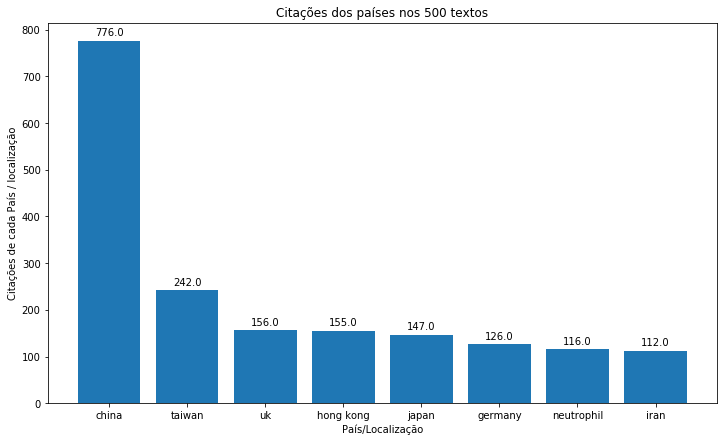

In [23]:
fig, ax = plt.subplots(figsize=(12,7))
rect1 = ax.bar(x=gpe_df["value"], height=gpe_df["counts"])
plt.title("Citações dos países nos 500 textos")
plt.ylabel('Citações de cada País / localização')
plt.xlabel('País/Localização')
autolabel(rect1)

Agora começarei a parte de como explorar os textos!! Primeiramente a busca por apenas uma palavra, temos o retorno do artigo, quantidade de vezes que a palavra foi achada e o abstract

In [94]:
def find_all_texts(input_str, search_str, number_of_words):
    text_list = []
    index = 0
    number_of_words = number_of_words
    while index < len(input_str):
        i = input_str.find(search_str, index)
        if i == -1:
            return text_list
    
        if input_str[i-number_of_words:i] == '':
            start = 0
        else:
            start = i - number_of_words
    
        text_list.append(input_str[start:i] + input_str[i:i + number_of_words])
        index = i + i
    return text_list

In [27]:
nlp = en_core_sci_md.load(disable = ['tagger', 'parser', 'ner'])
nlp.max_length = 2000000

In [28]:
def spacy_tokenizer(sentence):
    sentence = sentence.lower()
    lista = []
    lista = [word.lemma_ for word in nlp(sentence) if not (word.is_stop or
                                                         word.like_num or
                                                         word.is_punct or 
                                                         word.is_space or
                                                         len(word)==1)]
    lista = ' '.join([str(element) for element in lista])
    return lista

A seguir, será feita a busca por palavras, conforme o desejo do especialista de saúde.

**OBS: Realizei o código em HTML porém o github não estava aceitando, tive que reescrever**

In [44]:
search_strings = ['city', 'traveller']
tokens_list = [nlp(spacy_tokenizer(item)) for item in search_strings]
tokens_list

[city, traveller]

In [45]:
from spacy.matcher import PhraseMatcher
matcher = PhraseMatcher(nlp.vocab)
matcher.add("SEARCH", None, *tokens_list)
number_of_words = 50

In [47]:
for index, row in corona_df.iterrows():
    marked_text = ""
    doc = nlp(row["text"])
    paper_id = row["paper_id"]
    title=row['title']
    matches = matcher(doc)
    if matches == []:
        continue
        
    print(f"\n \n \nText: {search_strings}\n")
    print(f"Title: {title}\n")
    print(f"Paper ID: {paper_id}\n")
    print(f"Matches: {len(matches)}\n")
    
    for i in matches:
        start=i[1] - number_of_words
        if start<0:
            start=0
        for j in range(len(tokens_list)):
            if doc[i[1]:i[2]].similarity(tokens_list[j]) ==1:
                search_text = str(tokens_list[j])
                market_text = str(doc[start:i[2] + number_of_words]).replace(search_text, search_text)
                print(f"TEXTO: {market_text}")


 
 
Text: ['city', 'traveller']

Title: Exploring motivations behind pollution- mask use in a sample of young adults in urban China

Paper ID: d0cd9dce26de5d011fa364f5131d8e40630ead35

Matches: 2

TEXTO: individual health air pollution represent direct drag public resource rise cost health system indirect hindrance economic social order incentivizing mass emigration chinese government launch five-year plan radically tighten air pollution initiate process green growth development asia-pacific economic cooperation chinese government successfully implement rigorous emission reduction initiative low air pollution level city beijing experiment achieve excellent result demonstrate pollution tackle adequate policy measure positive effect measure health likely emerge long-run far clear government success redress pollution effect individual affect individual responsibly handle preventive health measure deal pollution chinese government take fact initiative leverage mass medium dissemination en


 
 
Text: ['city', 'traveller']

Title: Evaluating the impact of international airline suspensions on the early global spread of COVID-19

Paper ID: ba3efcd6b74e55327fd7db470d824fc18943f30e

Matches: 1

TEXTO: effective distance china figure country have high increase finally present analysis compare difference estimate versus report time arrival respect different component score idvi figure investigate potential factor explain report delay multiple ongoing attempt use airline traffic datum quantify global risk pose covid-19 author employ air travel volume obtain iata major city china rank country idvi convey vulnerability consider task forecast international domestic spread covid-19 employ official airline group oag datum determine air traffic country fit generalize linear model observe numb case country function air traffic volume obtain oag datum author refer determine country potential risk under-detection provide africa-specific case-study vulnerability preparedness

 
 
Text: ['


 
 
Text: ['city', 'traveller']

Title: Emerging and re-emerging infectious diseases in Iran

Paper ID: 33c50b9e506abf3c1db6bf58bd77b97155f9e903

Matches: 3

TEXTO: transplantation iran virus introduce emerge viral infection high risk population like inject drug user group show high prevalence hcv recent year study conduct healthy blood donor reveal seroconversion hcv infection time iran hcv infection prevalence low rate general population iran compare adjacent country pakistan turkey iraq infection blood donor different city country different dialysis center diverse frequency hcv infection range main route hcv transmission hemophilia thalassemia patient blood product year hcv antibody positive case confirm multi-transfused child β-thalassemia shiraz blood bank multicenter study point thalassemia patient suffer hcv infection infection rate vary recent year serological study show patient hemophilia antibody hcv
TEXTO: northeastern iran continuous report htlv-1 infection blood donor pat


 
 
Text: ['city', 'traveller']

Title: A water-focused one-health approach for early detection and prevention of viral outbreaks

Paper ID: 3edd89544597d9f178b831aa1047475fe3910871

Matches: 1

TEXTO: concentration excrete virus clinical case report employ europe quantify illicit drug use population wastewaterbased epidemiology apply quantify approximate concentration virus population service wastewater treatment plant urban wastewater treatment plant serve metropolitan area interceptor wastewater collect sample interceptor map interceptor specific neighborhood serve facilitate virus occurrence datum collection representative service area city viral concentration observe high interceptor rest correspond service area great concern potential viral outbreak sample rural area complex necessitate determination environment sample base watershed model microbial source track factor importance attain reliable datum wastewater-based epidemiology normalization population vital ensure significan


 
 
Text: ['city', 'traveller']

Title: A Long-Term Study of a Lipid-Buprenorphine Implant in Rats

Paper ID: 44c4f131824378c773a3b2e006bed411214feec7

Matches: 1

TEXTO: study use animal appear normal prior dose drug injection rat house cage day prevent redosing coprophagy day rat house cage house consist soft fiber contact bed carefresh natural bed ferndale wa ad libitum access harlan teklad certify global rodent diet 2016c harlan teklad indianapolis ad libitum access drink water baltimore city water system baltimore md disposable water bottle animal provide ad libitum access harlan teklad certify global rodent diet 2016c harlan teklad indianapolis rat provide enrichment device polycarbonate red tube bio service uden nl static microisolator cage change weekly design label dose mg/kg buprenorphine provide day clinically significant blood level drug

 
 
Text: ['city', 'traveller']

Title: Urbanisation and health in China

Paper ID: e5512ef2deb3da83b43c63bd66e74e7101a8042a

Matches: 2


 
 
Text: ['city', 'traveller']

Title: Early Prediction of Disease Progression in 2019 Novel Coronavirus Pneumonia Patients Outside Wuhan with CT and Clinical Characteristics

Paper ID: 4e2bc97a6164191ba3d53abfa49ccd973aa80326

Matches: 3

TEXTO: ards subsequent multiple organ dysfunction syndrome mod early identification patient high risk develop ards mod risk stratification management helpful reduce mortality cohort prevalence severe ncp cc-by-nc-nd international license available author/funder grant medrxiv license display preprint perpetuity peer-reviewed copyright holder preprint low large-scale report main cause patient moderate admission enroll single city find progressive patient old great numb underlie hypertension stable patient datum agreement recent report suggest age history hypertension risk factor short-term progression study show progressive patient low baseline lymphocyte count high nlr c-reactive protein covid-19 virus act lymphocyte severe acute respiratory syndrom


 
 
Text: ['city', 'traveller']

Title: a section of the journal Frontiers in Physiology Citation: Proteomic Analysis of Chicken Skeletal Muscle during Embryonic Development

Paper ID: 93507716d80b9834a1ee584b038c1be54c0790a8

Matches: 1

TEXTO: university guangzhou china incubate automatic incubator oscilla shandong china relative humidity chicken embryo sex identify pcr amplification chd1 chromodomain helicase dna bind protein gene fridolfsson ellegren leg muscle female xinghua chicken different development stage e11 e16 d1 itraq analysis female chicken stage e11 e16 d1 itraq assay apply biosystems foster city usa total protein extract urea lysis buff urea thiourea sds contain mm pmsf protein quantify bca assay kit pierce thermo usa detect sdselectrophoresis total protein treat follow reduction cysteine alkylation trypsin digestion obtain peptide equal amount peptide sample label individually different itraq reagent e11 label e16 label d1 label instruction

 
 
Text: ['city', 'trave


 
 
Text: ['city', 'traveller']

Title: Successful natural interferon-b plus ribavirin therapy in a chronic hepatitis C patient after discontinuation of interferon-a treatment due to arrhythmia and interstitial pneumonia

Paper ID: 1b6616fe20c678e18915ea2b6fab8b22309b45b6

Matches: 1

TEXTO: patient advance live stage prevent hepatocellular carcinoma ifns remain treatment choice patient good tolerance conclusion nifn-b plus rbv therapy alternative treatment option patient fail tolerate adverse effect pegifn-a concomitant rbv therapy conflict interest author declare conflict interest ethical standard study approve medical ethic committee st marianna university school medicine yokohama city seibu hospital investigation conform principle outline declaration helsinki human/animal right procedure follow accordance ethical standard responsible committee human experimentation institutional national helsinki declaration revise 2008(5 inform consent inform consent obtain patient prior study op


 
 
Text: ['city', 'traveller']

Title: Abstracts

Paper ID: f0d2dc18c4737a62d2de12b56d4dba143d21344a

Matches: 3

TEXTO: spain method random sample general population serum hiv-infected patient autonomous community castilla-leon collect seroprevalence antibody l. infantum determine indirect enzymoimmunoanalysis eia test design laboratory result anti-leishmania infantum antibody seroprevalence general population significant increase seroprevalence age year group year old significant difference woman man versus seroprevalence significantly high people rural area city versus hiv-infected patient seroprevalence l. infantum difference observe woman man prevalence increase age efficacy intralesional pentavalent antimony combination oral azole treatment oldworld cutaneous leishmaniasis result 30-year-old man present 6-month history slowly grow round lesion right arm leg history travel mediterranean area include north african middle east country month prior presentation
TEXTO: emergence crim


 
 
Text: ['city', 'traveller']

Title: Ionizing air affects influenza virus infectivity and prevents airborne- transmission OPEN

Paper ID: c831071c9229a681189522e08cfc3b64f84f95db

Matches: 1

TEXTO: reaction carry min produce cdna late real-time pcr quantitative real-time pcr rotavirus rhesus rotavirus detect quantify lux real-time pcr assay describe previously real-time pcr use label primer different fluorophore vp6 subgroup external plasmid standard semi-quantification quantitative real-time pcr cacv cacv detect quantify sybr green assay abi prism apply biosystems foster city primer final concentration nm cacv-3 5-accaacggaggattgccatc-3 nucleotide accord genbank accession no. af053720 cacv-4 5´-tagccgatcccacaagaagaca-3 nucleotide specific cacv strain reaction perform cdna 2x sybr green pcr master mix apply biosystems water final volume l. follow cycle program min follow cycle second min melt curve analysis perform immediately pcr completion heat second

 
 
Text: ['city', 'travel


 
 
Text: ['city', 'traveller']

Title: Emerging Microbes & Infections (2017) 6, e49

Paper ID: d1c3da8411eed001028326eb33acfb6bcdac877c

Matches: 1

TEXTO: rt-pcr reagent invitrogen carlsbad usa describe previously modification reagent mixture μl contain reaction mix superscript iii rt/platinum taq mix rox reagent μm forward reverse primer μm probe μl tna template thermal cycle condition min reverse transcription min rt inactivation/initial denaturation cycle reaction perform steponeplus real-time pcr system apply biosystems foster city usa qrt-pcr detection influenza virus parainfluenza virus hmpv respiratory syncytial virus carry agpath-id one-step rt-pcr reagent apply biosystems reagent mixture μl contain rt-pcr buff rt-pcr enzyme mix μm forward reverse primer μm probe μl tna template thermal cycle condition min reverse transcription min rt inactivation/initial denaturation cycle reaction perform lightcycler

 
 
Text: ['city', 'traveller']

Title: A time-trend ecological study fo


 
 
Text: ['city', 'traveller']

Title: A killed Leishmania vaccine with sand fly saliva extract and saponin adjuvant displays immunogenicity in dogs

Paper ID: 1d8ed60ab07f4ba567277143966536d7ffb7e6ea

Matches: 1

TEXTO: ciências exatas biológicas universidade federal de ouro preto ouro preto minas gerais brazil vaccinate age month rabies tecpar curitiba-pr brazil canine distemper type adenovirus coronavirus parainfluenza parvovirus leptospira vanguard htlp 5/cv-l pfizer animal health new york ny usa treat anthelmintic absence specific anti-leishmania antibody confirm indirect fluorescence immunoassay ouro preto city consider non-endemic area visceral leishmaniasis brazil negative serology ifat additional effective approach perform aim rule leishmania infection spray kennel ufop pyrethroid insecticide protect extension appropriate security stainless steel gauze recommend brazilian ministry healthy animal treat experimental group control group receive ml sterile saline ii sap group re

O próximo desafio é verificar a similaridade de alguns textos com os artigos, obtendo aqueles artigos que possuem uma maior similaridade

Um dos textos propostos é: 'Guidance on ways to scale up NPIs in a more coordinated way (e.g., establish funding, infrastructure and authorities to support real time, authoritative (qualified participants) collaboration with all states to gain consensus on consistent guidance and to mobilize resources to geographic areas where critical shortfalls are identified) to give us time to enhance our health care delivery system capacity to respond to an increase in cases. Rapid design and execution of experiments to examine and compare NPIs currently being implemented. DHS Centers for Excellence could potentially be leveraged to conduct these experiments'

In [48]:
texts = corona_df['text'].tolist()
tfidf = TfidfVectorizer()
vectorized = tfidf.fit_transform(texts)

In [49]:
search_string = 'Guidance on ways to scale up NPIs in a more coordinated way (e.g., establish funding, infrastructure and authorities to support real time, authoritative (qualified participants) collaboration with all states to gain consensus on consistent guidance and to mobilize resources to geographic areas where critical shortfalls are identified) to give us time to enhance our health care delivery system capacity to respond to an increase in cases. Rapid design and execution of experiments to examine and compare NPIs currently being implemented. DHS Centers for Excellence could potentially be leveraged to conduct these experiments'

In [50]:
search_string = spacy_tokenizer(search_string)
print(search_string)

guidance way scale npis coordinate way e.g. establish fund infrastructure authority support real time authoritative qualify participant collaboration state gain consensus consistent guidance mobilize resource geographic area critical shortfall identify time enhance health care delivery system capacity respond increase case rapid design execution experiment examine compare npis currently implement dhs center excellence potentially leverage conduct experiment


In [51]:
search_string_vectorized = tfidf.transform([search_string])

In [52]:
similarity = cosine_similarity(search_string_vectorized, vectorized)

In [53]:
scores_dict = {}
for i in range(len(similarity[0])):
    scores_dict[i] = similarity[0][i]

In [54]:
sorted_scores = sorted(scores_dict.items(), key=operator.itemgetter(1), reverse = True)

**Aqui então temos por ordem de importância, aqueles artigos onde foi encontrado uma maior similaridade com a frase pesquisada, lembrando que aqui estamos utilizando apenas em 500 artigos, porém pode ser utilizado em todos os outros do banco de dados**

In [58]:
for i in sorted_scores[:10]:
    df=corona_df.iloc[i[0]]
    print(f"Title: {df['title']}")
    print(f"Paper ID: {df['paper_id']}")
    print(f"Score: {i[1]}")
    print(f"Abstract: {str(df['abstract'])[0:500]}")
    print("-------------------------------------------------------------------")

Title: Establishment of CDC Global Rapid Response Team to Ensure Global Health Security
Paper ID: 6699fa6eb0b4fb603f3baf51add71f7ec29ed2a5
Score: 0.11836610700901243
Abstract: The 2014-2016 Ebola virus disease epidemic in West Africa highlighted challenges faced by the global response to a large public health emergency. Consequently, the US Centers for Disease Control and Prevention established the Global Rapid Response Team (GRRT) to strengthen emergency response capacity to global health threats, thereby ensuring global health security. Dedicated GRRT staff can be rapidly mobilized for extended missions, improving partner coordination and the continuity of response 
-------------------------------------------------------------------
Title: Policy-driven ecosystems for new vaccine development
Paper ID: e367c185f028a3b59af2e04b387e2fc72656641b
Score: 0.09705453964932752
Abstract: This paper examines the relationship between biomedical policies and entrepreneurial R&D strategies. Public

**A seguir será realizado alguns testes para saber se é possível prever com algum modelo o número de mortes pelo covid aqui no Brasil, e sempre lembrando que esse trabalho é apenas para fins teóricos e de aprendizado. Explicarei também um pouco do modelo que será utilizado para as previsões. A intenção não é contar mortes!! O primeiro dataset que estarei trabalhando, a data irá do dia 17/03 (dia do primeiro caso de morte) até o dia 28/6, e então farei previsões utilizando modelos estatísticos e de machine learning com a finalidade de tentar prever os próximos dias**

In [59]:
df_brasil = pd.read_csv("brazil_covid19_macro.csv")
brasil = df_brasil[['date', 'deaths']].groupby('date').sum().reset_index()
brasil = brasil[brasil['deaths'] >0]
brasil['date'] = pd.to_datetime(brasil['date'])
brasil.set_index('date', inplace=True)
brasil.index.freq = "D"

In [60]:
brasil.head()

,deaths
date,
2020-03-17,1
2020-03-18,4
2020-03-19,6
2020-03-20,11
2020-03-21,18


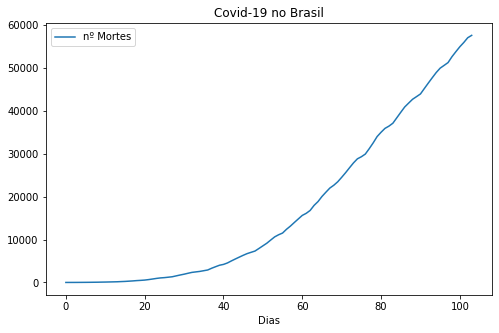

In [61]:
plt.figure(figsize=(8,5))
plt.title("Covid-19 no Brasil")
plt.plot(brasil.values,label="nº Mortes")
plt.xlabel("Dias")
plt.legend()

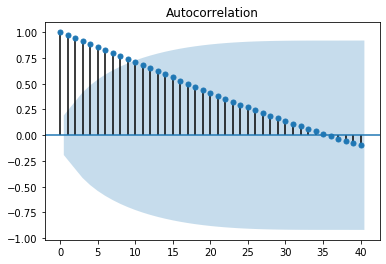

In [62]:
plot_acf(brasil['deaths'], lags=40);

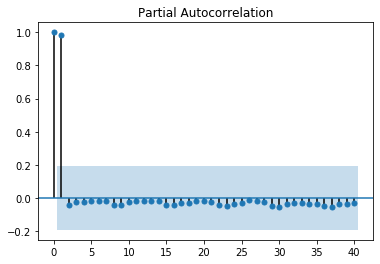

In [63]:
plot_pacf(brasil['deaths'], lags=40);

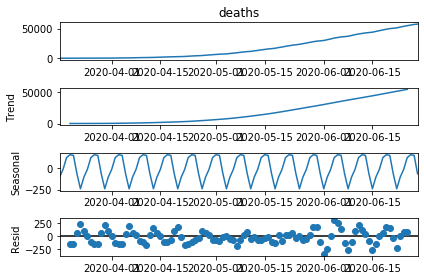

In [64]:
seasonal = seasonal_decompose(brasil['deaths'], model='aditive');
seasonal.plot();

**Podemos então dividir o primeiro gráfico entre a tendência, a sazonalidade e o residuo**

A tendência é em que forma que o gráfico está se aprensentando? Em alta? Em queda?

Sazonalidade é os períodos que se repetem, por exemplo, no inverno as pessoas costumam viajar mais do que no verão, e isso se repete todo ano

Residuo é tudo aquilo que não pode ser explicado pela tendência e pela sazonalidade

A seguir podemos aproximar a sazonalidade e afirmar que existe uma sazonalidade semanal aos finais de semana, isso poderia ser explicado pelo atraso dos dados aos sábados e domingos

Text(0.5, 0, 'Date')

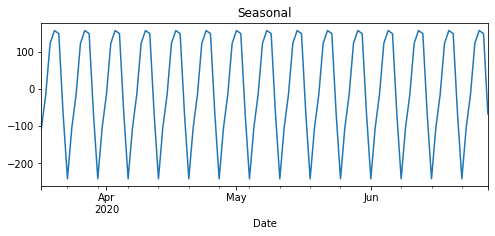

In [65]:
plt.figure(figsize=(8,3))
seasonal.seasonal.plot();
plt.title("Seasonal")
plt.xlabel('Date')

Abaixo temos o gráfico de tendência, como ja poderíamos supor, existe uma tendência de alta nos números de mortes

Text(0.5, 0, 'Date')

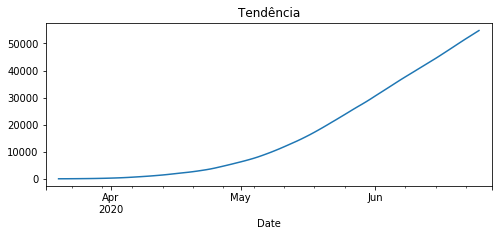

In [66]:
plt.figure(figsize=(8,3))
seasonal.trend.plot()
plt.title("Tendência")
plt.xlabel('Date')

Abaixo vemos o gráfico de resíduos, que é tudo aquilo que não pode ser explicado nem pela tendência e nem pela sazonalidade

Text(0.5, 0, 'Date')

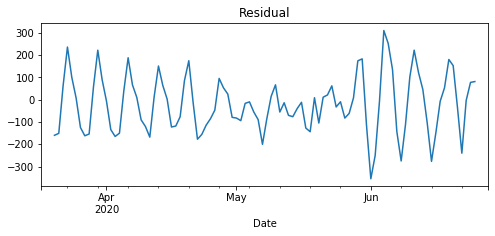

In [67]:
plt.figure(figsize=(8,3))
seasonal.resid.plot()
plt.title("Residual")
plt.xlabel('Date')

A seguir devemos então verificar se a série é estacionária ou não, para isso é utilizaremos o teste do adfuller

O seguinte teste retornará uma tupla de estatísticas do teste do ADF, como Estatística do teste Valor-P; Número de defasagens usadas; Número de observações usadas para a regressão do ADF e um dicionário de Valores críticos.

Resumindo, se o valor-p encontrado pelo teste for < 0,05, a série é estacionária, ja se o valor for acima de 0,05 a série não é estacionária e por esse motivo devemos então normalizala.

**Utilizei uma função para simplificar a visualização dos valores, e o valor p encontrado foi superior a 0,05, ou seja, a série não é estacionaria e para realizar as previsões devemos transforma-la em estacionária**

In [68]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [69]:
adf_test(brasil["deaths"])

Augmented Dickey-Fuller Test: 
ADF test statistic      -2.129313
p-value                  0.232892
# lags used              8.000000
# observations          95.000000
critical value (1%)     -3.501137
critical value (5%)     -2.892480
critical value (10%)    -2.583275
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Para transformar em uma série estacionária, foi necessária a realização de 2 diferenciações.

Text(0, 0.5, 'Date')

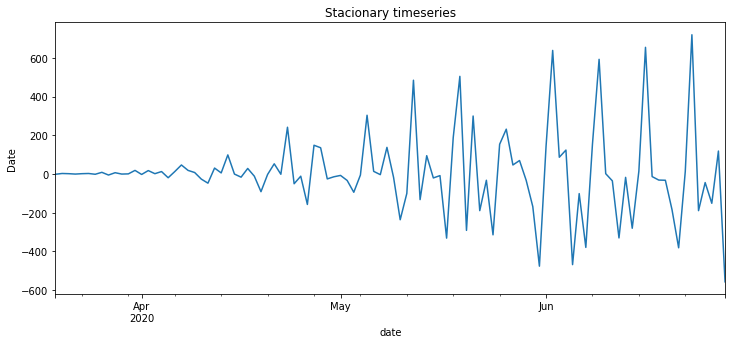

In [70]:
df1 = brasil.copy()
plt.figure(figsize=(12,5))
df1['d2'] = diff(brasil['deaths'],k_diff=2)
df1['d2'][2:].plot();
plt.title("Stacionary timeseries")
plt.ylabel("Date")

In [71]:
adf_test(df1['d2'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -5.494940
p-value                  0.000002
# lags used              6.000000
# observations          95.000000
critical value (1%)     -3.501137
critical value (5%)     -2.892480
critical value (10%)    -2.583275
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


**Como podemos ver, agora se tornou uma série estacionária!!**

MODELO SARIMA

De uma forma resumida, o ARIMA model é composto por:

AR(p) = Autoregression model, prevemos utilizando a combinação de valores passados da próprima variável. Gera modelos lineares.

Representado pela letra P MA(d) = é o modelo de média móvel. ARMA(p,q) = A junção dos dois acima - representado pela letra Q

ARIMA(p,q,d) = O mesmo processo que ocorre para o ARMA + aplicação da diferenciação para tornar a série estacionária.

Temos então o SARIMAX (termo genérico), além dos parâmetros (p,q,d) aceita também o (P,D,Q)m, descrevendo os componentes sazonais. P,D e Q representa a regressão sazonal, diferenciação, e média movel, m representa o número de pontos para cada ciclo.

O X representa a variável exógena, como não utilizaremos ela, não entrarei em maiores detalhes.

Para a definição dos melhores parâmetros existe a forma manual e a forma automática, onde a função definirá os melhores parâmetros para nós...

Função: Auto_arima, devo informar ainda o meu dataset, definir os pontos de start do "p" e do "q", definir a sazonalidade e o período de sazonalidade, no caso são de 7 dias.

O objetivo é achar os melhores parâmetros em base no valor AIC, que deve ser o menor possível, com a menor complexidade

Essa ferramenta impede que cometemos erros na hora de analisar os gráficos e realizar transformações nos dados, assim ele nos informa os melhores parâmetros!!

In [72]:
train_set = brasil[:90]
test_set = brasil[90:]

In [73]:
sarima = auto_arima(brasil['deaths'],start_p=0, start_q=0,seasonal=True,trace=True, m=7)

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(1,1,1,7) [intercept=True]; AIC=1204.234, BIC=1214.491, Time=0.663 seconds
Fit ARIMA(0,1,0)x(0,1,0,7) [intercept=True]; AIC=1202.494, BIC=1207.622, Time=0.015 seconds
Fit ARIMA(1,1,0)x(1,1,0,7) [intercept=True]; AIC=1181.905, BIC=1192.163, Time=0.449 seconds
Fit ARIMA(0,1,1)x(0,1,1,7) [intercept=True]; AIC=1189.856, BIC=1200.113, Time=0.480 seconds
Fit ARIMA(0,1,0)x(0,1,0,7) [intercept=False]; AIC=1228.579, BIC=1231.143, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,1,0,7) [intercept=True]; AIC=1185.071, BIC=1192.764, Time=0.033 seconds
Fit ARIMA(1,1,0)x(2,1,0,7) [intercept=True]; AIC=1182.186, BIC=1195.008, Time=1.188 seconds
Fit ARIMA(1,1,0)x(1,1,1,7) [intercept=True]; AIC=1183.003, BIC=1195.824, Time=0.628 seconds
Fit ARIMA(1,1,0)x(0,1,1,7) [intercept=True]; AIC=1181.023, BIC=1191.280, Time=0.406 seconds
Fit ARIMA(1,1,0)x(0,1,2,7) [intercept=True]; AIC=1182.987, BIC=1195.808, Time=1.039 seconds
Fit ARIMA(1,1,0)x(1,1,2,7) [intercep

In [74]:
sarima

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 1, 1, 7),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [75]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  104
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 7)   Log Likelihood                -581.034
Date:                             Thu, 09 Jul 2020   AIC                           1178.067
Time:                                     00:14:23   BIC                           1198.582
Sample:                                          0   HQIC                          1186.360
                                             - 104                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.5665     10.884      0.420      0.675     -16.766      25.899
ar.L1          0.1500      0.198      0.759      0.448      -0.238       0.538
ar.L2          0.7731      0.156      4.949      0.000       0.467       1.079
ma.L1          0.3260      0.221      1.475      0.140      -0.107       0.759
ma.L2         -0.5555      0.173     -3.217      0.001      -0.894      -0.217
ma.L3         -0.3246      0.097     -3.331      0.001      -0.516      -0.134
ma.S.L7       -0.3359      0.119     -2.833      0.005      -0.568      -0.103
sigma2      1.049e+04   1512.204      6.937      0.000    7526.376    1.35e+04
===================================================================================
Ljung-Box (Q):                       39.26   Jarque-Bera (JB):                 5.57
Prob(Q):                              0.50   Prob(JB):                         0.06
Heteroskedasticity (H):               6.21   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [76]:
start = len(train_set)
end = len(train_set) + len(test_set) - 1

In [77]:
model = SARIMAX(train_set['deaths'], order=(2, 1, 3),seasonal_order=(0, 1, 1, 7)).fit()

In [78]:
predictions = model.predict(start,end,typ="levels").rename("SARIMAX(2, 1, 3)x(0, 1, 1, 7)")

In [79]:
predictions

2020-06-15    44056.968045
2020-06-16    45337.891789
2020-06-17    46619.155816
2020-06-18    47927.410451
2020-06-19    48893.412260
2020-06-20    49820.102115
2020-06-21    50424.599803
2020-06-22    51157.949686
2020-06-23    52449.119570
2020-06-24    53747.950835
2020-06-25    55067.581341
2020-06-26    56049.315385
2020-06-27    56987.876339
2020-06-28    57606.801725
Freq: D, Name: SARIMAX(2, 1, 3)x(0, 1, 1, 7), dtype: float64

Nos gráficos abaixo podemos ver que as predições foram muito próximas aos valores de teste!! O que faremos depois é prever por mais uma semana e depois conferir com os dados

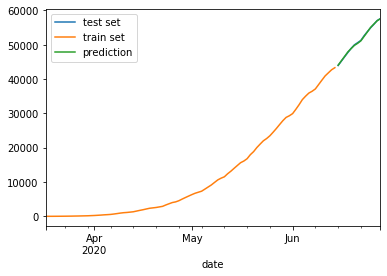

In [80]:
test_set['deaths'].plot(label="test set", legend=True)
train_set['deaths'].plot(legend=True, label="train set")
predictions.plot(label="prediction", legend=True)

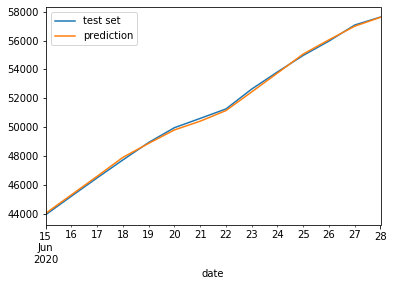

In [81]:
test_set['deaths'].plot(label="test set", legend=True)
predictions.plot(label="prediction", legend=True)

In [82]:
rmse(test_set['deaths'], predictions)

122.4937744570288

In [83]:
start = len(train_set)
end = len(train_set) + len(test_set) + 6

In [84]:
predictions = model.predict(start,end,typ="levels").rename("SARIMAX(2, 1, 3)x(0, 1, 1, 7)")

In [85]:
predictions

2020-06-15    44056.968045
2020-06-16    45337.891789
2020-06-17    46619.155816
2020-06-18    47927.410451
2020-06-19    48893.412260
2020-06-20    49820.102115
2020-06-21    50424.599803
2020-06-22    51157.949686
2020-06-23    52449.119570
2020-06-24    53747.950835
2020-06-25    55067.581341
2020-06-26    56049.315385
2020-06-27    56987.876339
2020-06-28    57606.801725
2020-06-29    58352.139145
2020-06-30    59656.761888
2020-07-01    60967.473615
2020-07-02    62299.789460
2020-07-03    63293.167572
2020-07-04    64243.778964
2020-07-05    64874.039755
Freq: D, Name: SARIMAX(2, 1, 3)x(0, 1, 1, 7), dtype: float64

In [86]:
brasil_covid = pd.read_csv("brasil_covid.csv", index_col=1, parse_dates=True,dayfirst=True, sep=";")

In [87]:
comparacao = brasil_covid[-21:]

Text(0.5, 0, 'Data')

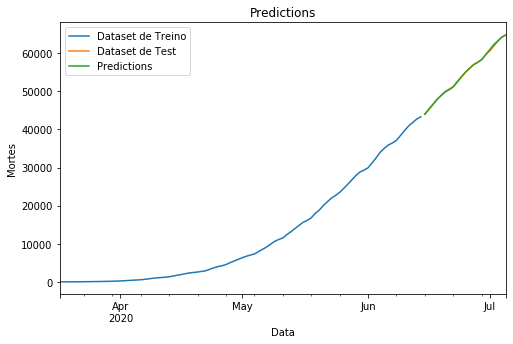

In [88]:
plt.figure(figsize=(8,5))
train_set['deaths'].plot(legend=True, label="Dataset de Treino")
comparacao["obitosAcumulado"].plot(legend=True, label="Dataset de Test")
predictions.plot(legend=True, label="Predictions")
plt.title("Predictions")
plt.ylabel("Mortes")
plt.xlabel("Data")


Novamente os valores foram muito próximos aos reais, chegando ao dia 5 com erro de 7 mortes no total acumulado

Text(0.5, 0, 'Data')

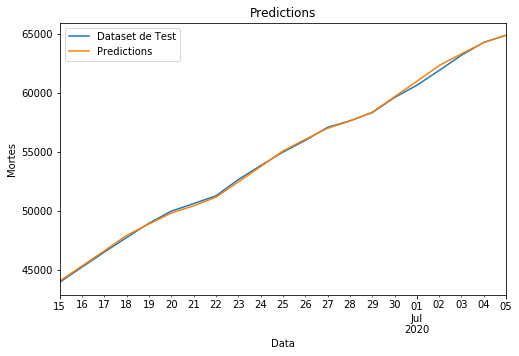

In [89]:
plt.figure(figsize=(8,5))
comparacao["obitosAcumulado"].plot(legend=True, label="Dataset de Test")
predictions.plot(legend=True, label="Predictions")
plt.title("Predictions")
plt.ylabel("Mortes")
plt.xlabel("Data")

In [90]:
dataframe = pd.DataFrame({"predictions": predictions.values,
                          "mortes":comparacao['obitosAcumulado']})

In [91]:
dataframe['diferença'] = dataframe['predictions'] - dataframe['mortes']

In [92]:
dataframe['diferença'] = dataframe['diferença'].astype(int)

In [93]:
dataframe

,predictions,mortes,diferença
data,,,
2020-06-15,44056.968045,43959,97
2020-06-16,45337.891789,45241,96
2020-06-17,46619.155816,46510,109
2020-06-18,47927.410451,47748,179
2020-06-19,48893.412260,48954,-60
2020-06-20,49820.102115,49976,-155
2020-06-21,50424.599803,50617,-192
2020-06-22,51157.949686,51271,-113
2020-06-23,52449.119570,52645,-195


**CONCLUSÃO:**

**Podemos ver de uma forma simplificada, como a utilização do machine learning e técnicas de Inteligência Artificial, podem contribuir para a soluções de alguns problemas e pode também automatizar tarefas que poderiam levar muito tempo. Podemos concluir que com a utilização de modelos preditivos, é possível prever com uma certa precisão os números de mortes para que as governantes possam tomar atitudes acertivas.**

Algumas considerações:

As previsões foram feitas apenas com relação as datas, mas outros fatores podem inteferir nos números.

Qualquer tipo de erro que eu cometi, podem entrar em contado, sempre gosto de críticas e sugestões

Para a exploração dos textos foi utilizado apenas 500 textos de forma 'aleatória' pois caso utilizasse os 20 mil, tomaria muito tempo de processamento.

Algumas das funções utilizadas tomei como base de outros trabalhos, sendo assim, citei quando necessário.

A apresentação de algumas funções eram para ser em html, porém o não foi possível com o github